[[ 0.10105743 -1.5267496 ]
 [-1.1036341  -3.3080626 ]
 [ 1.2999071   0.31110066]]
[[ 0.07681631]
 [-0.3274296 ]
 [-0.3175006 ]]
[[2.573491  ]
 [0.0741588 ]
 [0.07396404]]


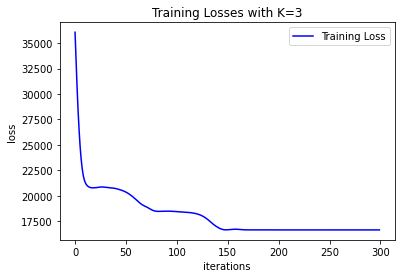

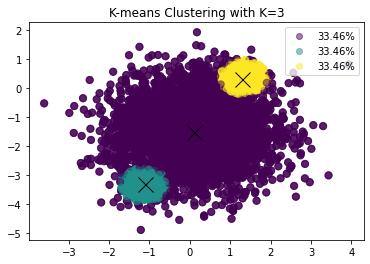

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import helper as hlp

# Loading data
#data = np.load('data100D.npy')
data = np.load('data2D.npy')
[num_pts, dim] = np.shape(data)

is_valid=False
# For Validation set
if is_valid:
  valid_batch = int(num_pts / 3.0)
  np.random.seed(45689)
  rnd_idx = np.arange(num_pts)
  np.random.shuffle(rnd_idx)
  val_data = data[rnd_idx[:valid_batch]]
  data = data[rnd_idx[valid_batch:]]

# Distance function for K-means
def distanceFunc(X, MU):
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions)
    # MU: is an KxD matrix (K means and D dimensions)
    X = tf.expand_dims(X,1)
    MU = tf.expand_dims(MU,0)
    pair_dist = tf.reduce_sum(tf.square(tf.subtract(X, MU)), axis=2)
    # Outputs
    # pair_dist: is the squared pairwise distance matrix (NxK)
    return pair_dist

def log_GaussPDF(X, MU, sigma):
    # Inputs
    # X: N X D
    # mu: K X D
    # sigma: K X 1
    # Outputs:
    # log Gaussian PDF N X K
    return -0.5*(tf.transpose(tf.log(2*np.pi*sigma))+(distanceFunc(X,MU)/tf.transpose(sigma)))

def log_posterior(log_PDF, log_pi):
    # Input
    # log_PDF: log Gaussian PDF N X K
    # log_pi: K X 1
    # Outputs
    # log_post: N X K
    Npi = log_PDF+tf.transpose(log_pi)
    return (Npi)-hlp.reduce_logsumexp(Npi,keep_dims=True)


#initialize variables and placeholders
#all_losses = []
#for K in [5,10,15,20,30]:
K=3
X = tf.placeholder("float", (None, dim), name='X')
MU = tf.Variable(tf.random.truncated_normal(shape=(K, dim),mean=0.0,stddev=1.0))
sigma = tf.exp(tf.Variable(tf.random.truncated_normal(shape=(K, 1),mean=0.0,stddev=1.0)))
pi = tf.Variable(tf.random.truncated_normal(shape=(K, 1),mean=0.0,stddev=1.0))

clusters = tf.argmax(log_posterior(log_GaussPDF(X, MU, sigma), hlp.logsoftmax(pi)),1)
loss = -tf.reduce_sum(hlp.reduce_logsumexp(tf.transpose(hlp.logsoftmax(pi)) + log_GaussPDF(X, MU, sigma), 1, keep_dims=True))
optiAndMini = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

losses = []
valid_losses = []

#training loop
for i in range(300):
  _, newMU, newPi, newSigma, x_loss, clustering= sess.run([optiAndMini, MU, pi, sigma,loss, clusters], feed_dict={X: data})
  losses.append(x_loss)
  #print("iteration: "+str(i)+" loss: "+str(x_loss))
  if is_valid:
    _, newMUV, v_loss, v_clustering= sess.run([optiAndMini, MU, loss, clusters], feed_dict={X: val_data})
    valid_losses.append(v_loss)
#print(valid_losses[-1])
#all_losses.append(valid_losses)
print(newMU)
print(newPi)
print(newSigma)
  #plot corresponding to loss functions
x_range = range(300)

if is_valid:
  plt.plot(x_range, all_losses[0], 'b', x_range, all_losses[1], 'r', x_range, all_losses[2], 'g', x_range, all_losses[3], 'm', x_range, all_losses[4], 'y')
  plt.xlabel('iterations')
  plt.ylabel('loss')
  plt.legend(['K=5', 'K=10', 'K=15', 'K=20', 'K=30'],loc='upper right')
  plt.title("Validation Losses with GMM")
  plt.show()
  print(valid_losses[-1])

else:
  plt.plot(x_range, losses, 'b')
  plt.xlabel('iterations')
  plt.ylabel('loss')
  plt.legend(["Training Loss"],loc='upper right')
  plt.title("Training Losses with K=3")
  plt.show()

  #calculate the percentage of data points in each cluster
  percentages = np.zeros(K)
  for k in range(K):
    percentages[k] = (np.sum(np.equal(k, clustering))/len(clustering))*100
  #  print(percentages[k])

  #plot the clusters
  plt.title("K-means Clustering with K="+str(K))
  #cmap = plt.get_cmap('Set1')
  for i in range(K):
    scatter = plt.scatter(data[:, 0], data[:, 1],c=clustering, s=50, alpha=0.5)
    kw = dict(fmt=f'{percentages[i]:.2f}%')
    legend2 = plt.legend(*scatter.legend_elements(**kw),loc="upper right")
    
  plt.plot(newMU[:, 0], newMU[:, 1], 'kx', markersize=15)